# AQI Calculation 
This notebook contains code associated with calculating the AQI in East Boston. This work's intention is to provide some context for whether or not Air Partners should pursue using AQI as an indicator by which to inform East Boston residents about the air quality. For more context, read the [assumption test](https://docs.google.com/document/d/1EtGzySFGZ5PVPhCsywW77AdkwYG_axO-Zp_cfnLsTVg/edit#) assorted with this work.

In [20]:
import bisect
import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Dataset Exploration
We are lucky enough to have a cleaned dataset (i.e. post filtering and QA/QC) available, stored as a tar file because of GitHub's size restrictions. Note that the cell below (and all of the cells that follow it) will not run until you un-tar the `cleaned_sn45.tar` file in the `data/` directory, which you can do with the command `tar -xvf data/cleaned_sn45.tar`.

Start by exploring and plotting the dataset. 

In [21]:
SN45 = pd.read_csv('cleaned_sn45.csv');
SN45.describe()


,temp_manifold,co,no,no2,o3,pm1,pm25,pm10,co2,bin0,no_ae,wd,ws,correctedNO
count,387704.000000,387262.000000,386561.000000,387693.000000,387703.000000,387704.000000,387704.000000,387704.000000,387703.000000,387704.000000,387704.000000,387704.000000,387704.000000,386240.000000
mean,13.647573,159.355256,5.148322,9.116818,22.393144,0.245195,0.435172,3.907743,506.734158,5.510000,666.034807,217.622026,4.967693,2.762795
std,8.825574,110.395796,12.005006,6.802572,7.620916,0.280186,0.482057,8.307378,93.149340,6.377054,15.342721,100.594908,2.594865,10.250056
min,-8.800000,0.026152,0.000100,0.396604,0.000000,0.000000,0.000000,0.000000,307.515074,0.000000,166.400000,10.000000,0.000000,0.000000
25%,7.100000,90.866311,1.691654,5.408743,17.245761,0.083653,0.145534,0.804356,392.380272,1.674000,662.100000,140.000000,2.569931,0.370723
50%,12.300000,132.757339,2.936063,7.780322,23.053606,0.151732,0.284262,1.718963,548.066478,3.182000,663.700000,230.000000,4.625875,1.032190
75%,20.400000,194.253347,4.868329,11.244448,27.753741,0.304699,0.545325,3.831488,566.288995,7.034000,667.400000,300.000000,6.681819,2.231443
max,68.400000,6055.571570,729.976933,608.128860,54.902919,10.091917,20.898884,534.991092,1650.903831,168.214000,3298.200000,360.000000,21.587417,729.998953


In [22]:
SN45.dtypes

date                  object
timestamp             object
timestamp_local       object
temp_manifold        float64
co                   float64
no                   float64
no2                  float64
o3                   float64
pm1                  float64
pm25                 float64
pm10                 float64
co2                  float64
bin0                 float64
no_ae                float64
originaldate          object
original_met_time     object
wd                     int64
ws                   float64
day                   object
correctedNO          float64
dtype: object

Make the timestamps nice datetime object, code in the cell bellow lifted from [SP19 exploration notebook](https://github.com/airpartners/data-analysis/blob/master/SP19-data-analysis-test.ipynb).

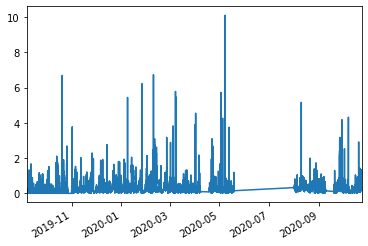

In [23]:
index = []
for ts in SN45.timestamp_local:
    Y = int(ts[:4])
    M = int(ts[5:7])
    D = int(ts[8:10])
    H = int(ts[11:13])
    T = int(ts[14:16])
    S = int(ts[17:19])
    index.append(dt.datetime(Y, M, D, H, T, S))
SN45.index = index
SN45.pm1.plot()

## Calculating AQI

Basic documentation of AQI calculation was surprisingly hard to find, especially if you try to use the EPA website. Scott provided these two awesome links with more information than I could find anywhere else:
- [AQI Calculation Overview](https://forum.airnowtech.org/t/aqi-calculations-overview-ozone-pm2-5-and-pm10/168)
- [How is AQI Calculated](https://stimulatedemissions.wordpress.com/2013/04/10/how-is-the-air-quality-index-aqi-calculated/)

This [article from the Minnesota pollution control agency](https://www.pca.state.mn.us/air/about-air-quality-data) contains some insight into AQI calculation and also contains the threshold used for this calculation.

To find the AQI associated with a particular particle concentration, first determine which AQI breakpoint bin the highest particle concentration measured within the timeframe associated with that particle (24 hours for most, but 1 hour for NO2 and 8 hours for O3 falls within. These bins vary country-by-country, and this uses the most up-to-date EPA thresholds I could find (from the Minnesota pollution control agency). The units match the units from our dataset.e

In [71]:
breakpoints = [0,50,100,150,200,300]
O3 =   [0.000, 59, 75, 95, 115, 375] # ppb max 8 hour
PM25 = [0.000, 12.1, 35.5, 55.5, 150.5, 250.5] # ug/m3 max 24 hr
PM10 = [0, 55, 155, 255, 355, 425] # ug/m3 max 24 hr
CO =   [0, 450, 950, 1250, 1550, 3050] #ppb max 24 hr
NO2 =  [0, 54, 101, 461, 650, 1241] #ppb max 1 hr

Using those bins, apply the following formula:

```
low_AQI + ((concentration - low_concentration) * ((high_AQI - low_AQI)/(high_concentration-low_concentration)))
```
Note that `low_AQI` and `low_concentration` correspond to the lower bounds associated with the interval the actual concentration (`concentration`) falls in, and `high_AQI` and `high_concentration` correspond with that same interval's higher bounds. 

In [79]:
def calculate_aqi_for_particle(concentration, particle_list, breakpoints=[0,50,100,150,200,300]):
    """
    Calculate the AQI value associated with some floating point concentration value (likely in parts
    per billion, must match the units on the particle list) given the list of concentration cutoffs and
    list of breakpoints that match those cutoffs. Note that this function generally assumes that expected
    input; add some input conditioning if this function is used for a production system.

    concentration: The highest particle concentration (matching units of particle_list) within the timespan of
    the given particle
    particle_list: The list of cutoffs for each breakpoint associated with the particle, matching units for concentration.
    breakpoints: The list of breakpoints associated with particle_list cutoffs, defaults to 0:50:200, 300
    
    returns: Computed AQI value for that particle.
    """
    # Truncate the concentration to three decimal places.
    truncation_factor = 10.0 ** 3
    concentration = math.trunc(concentration * truncation_factor) / truncation_factor
    high_index = bisect.bisect(particle_list, concentration)
    low_index = high_index - 1
    low_AQI = breakpoints[low_index]
    high_AQI = breakpoints[high_index]
    low_concentration = particle_list[low_index]
    high_concentration = particle_list[high_index]
    return low_AQI + ((concentration - low_concentration) * ((high_AQI - low_AQI)/(high_concentration-low_concentration)))
    
def calculate_overall_aqi(concentration_list, particle_lists):
    """
    Compute the overall AQI associated with a set of concentrations and bounds. The AQI is
    equal to the maximum AQI value computed for any particle within the suite of available
    measurements.
    """
    max_aqi = 0
    for concentration, particle_list in zip(concentration_list, particle_lists):
        max_aqi = max(max_aqi, calculate_aqi_for_particle(concentration, particle_list))
    return max_aqi

## Calculating AQI With Our Dataset

Using this dataset, we can find the AQI associated with a specific hour (as we take the maximum value of NO<sub>2</sub> from the most recent complete hour).
I'll start by doing the calculation using 

In [80]:
# Create 24, 8, and 1 hour dataframes for a specific (and arbitrary) date and time.
SN45_day = SN45[(SN45.index > '2020-03-17 9:00') & (SN45.index < '2020-03-18 8:59')]
SN45_8_hour = SN45[(SN45.index > '2020-03-17 9:00') & (SN45.index < '2020-03-17 16:59')]
SN45_1_hour = SN45[(SN45.index > '2020-03-17 9:00') & (SN45.index < '2020-03-17 9:59')]
# Get particle lists from earlier cell.
particle_lists = [O3, PM25, PM10, CO, NO2]
concentration_list = [SN45_8_hour["o3"].max(), SN45_day["pm25"].max(), SN45_day["pm10"].max(), SN45_day["co"].max(), SN45_1_hour["no2"].max()]
aqi = calculate_overall_aqi(concentration_list, particle_lists)
aqi

56.376

TODO Have a conclusion about whether or not its worth it.

In [81]:
SN45_8_hour

,date,timestamp,timestamp_local,temp_manifold,co,no,no2,o3,pm1,pm25,pm10,co2,bin0,no_ae,originaldate,original_met_time,wd,ws,day,correctedNO
2020-03-17 09:00:06,2020-03-17T09:00:00Z,2020-03-17T13:00:06Z,2020-03-17T09:00:06Z,5.4,194.818832,2.266615,6.598321,29.117352,0.122037,0.347635,3.947376,566.981473,2.648,661.5,2020-03-17T13:00:06Z,2020-03-17 09:00,150,6.681819,2020-03-17,0.015791
2020-03-17 09:01:06,2020-03-17T09:01:00Z,2020-03-17T13:01:06Z,2020-03-17T09:01:06Z,5.4,108.129740,2.266373,6.519483,29.574741,0.124781,0.354518,3.954260,566.695052,2.743,662.4,2020-03-17T13:01:06Z,NaN,150,6.681819,2020-03-17,0.016549
2020-03-17 09:02:06,2020-03-17T09:02:00Z,2020-03-17T13:02:06Z,2020-03-17T09:02:06Z,5.4,84.117229,2.268162,9.364230,28.160910,0.128713,0.362590,4.027781,565.740312,2.785,661.6,2020-03-17T13:02:06Z,NaN,150,6.681819,2020-03-17,0.019339
2020-03-17 09:04:06,2020-03-17T09:04:00Z,2020-03-17T13:04:06Z,2020-03-17T09:04:06Z,5.4,82.985800,2.267425,6.320845,29.902667,0.124742,0.350340,3.557383,565.740312,2.712,661.6,2020-03-17T13:04:06Z,NaN,150,6.681819,2020-03-17,0.019602
2020-03-17 09:05:06,2020-03-17T09:05:00Z,2020-03-17T13:05:06Z,2020-03-17T09:05:06Z,5.4,81.649277,2.267906,6.328512,28.782433,0.125707,0.347165,3.946907,565.262942,2.755,661.6,2020-03-17T13:05:06Z,2020-03-17 09:05,150,6.681819,2020-03-17,0.021084
2020-03-17 09:06:06,2020-03-17T09:06:00Z,2020-03-17T13:06:06Z,2020-03-17T09:06:06Z,5.4,79.426860,2.983245,7.629216,30.128618,0.126373,0.345762,3.880054,564.499150,2.787,662.1,2020-03-17T13:06:06Z,NaN,150,6.681819,2020-03-17,0.737423
2020-03-17 09:07:06,2020-03-17T09:07:00Z,2020-03-17T13:07:06Z,2020-03-17T09:07:06Z,5.4,80.971582,2.975362,6.358737,28.963546,0.126914,0.348372,3.751764,565.071994,2.784,661.6,2020-03-17T13:07:06Z,NaN,150,6.681819,2020-03-17,0.730541
2020-03-17 09:08:06,2020-03-17T09:08:00Z,2020-03-17T13:08:06Z,2020-03-17T09:08:06Z,5.4,89.617935,2.976901,8.189100,28.283277,0.130114,0.366061,4.031252,565.453890,2.872,661.7,2020-03-17T13:08:06Z,NaN,150,6.681819,2020-03-17,0.733079
2020-03-17 09:09:06,2020-03-17T09:09:00Z,2020-03-17T13:09:06Z,2020-03-17T09:09:06Z,5.4,88.380841,2.973317,7.259450,28.188906,0.134300,0.376456,4.237997,564.308203,3.009,661.6,2020-03-17T13:09:06Z,NaN,150,6.681819,2020-03-17,0.730496
2020-03-17 09:10:06,2020-03-17T09:10:00Z,2020-03-17T13:10:06Z,2020-03-17T09:10:06Z,5.4,92.702336,2.976060,7.259510,28.562372,0.130874,0.352332,3.952074,563.830833,2.910,661.6,2020-03-17T13:10:06Z,2020-03-17 09:10,150,6.681819,2020-03-17,0.734239
